In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
title_basics = pd.read_csv('data\imdb.title.basics.csv.gz')

In [3]:
title_ratings = pd.read_csv('data\imdb.title.ratings.csv.gz')

In [4]:
movie_budgets = pd.read_csv(r'data\tn.movie_budgets.csv.gz')

In [5]:
imdb_data = pd.merge(title_basics, title_ratings, how = 'inner', on = 'tconst')
imdb_data.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [6]:
imdb_data = imdb_data.drop(columns='runtime_minutes')

In [7]:
imdb_data

,tconst,primary_title,original_title,start_year,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,6.6,5


In [8]:
imdb_data = imdb_data.dropna(subset=['genres'])

In [9]:
imdb_data

,tconst,primary_title,original_title,start_year,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...
73850,tt9913056,Swarm Season,Swarm Season,2019,Documentary,6.2,5
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,Documentary,8.5,8


In [10]:
imdb_data = imdb_data.rename(columns={'primary_title': 'movie'})

In [11]:
imdb_data

,tconst,movie,original_title,start_year,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...
73850,tt9913056,Swarm Season,Swarm Season,2019,Documentary,6.2,5
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,Documentary,8.5,8


In [12]:
movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [13]:
mdf = pd.merge(imdb_data, movie_budgets, on=['movie'], how='inner')

In [14]:
mdf

,tconst,movie,original_title,start_year,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012","$45,000,000",$0,"$73,706"
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302"
2,tt4339118,On the Road,On the Road,2014,Drama,6.0,6,17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302"
3,tt5647250,On the Road,On the Road,2016,Drama,5.7,127,17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302"
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183"
...,...,...,...,...,...,...,...,...,...,...,...,...
2862,tt8680254,Richard III,Richard III,2016,Drama,9.1,28,65,"Dec 29, 1995","$9,200,000","$2,684,904","$4,199,334"
2863,tt8824064,Heroes,Heroes,2019,Documentary,7.3,7,12,"Oct 24, 2008","$400,000","$655,538","$655,538"
2864,tt8976772,Push,Push,2019,Documentary,7.3,33,70,"Feb 6, 2009","$38,000,000","$31,811,527","$49,678,401"
2865,tt9024106,Unplanned,Unplanned,2019,"Biography,Drama",6.3,5945,33,"Mar 29, 2019","$6,000,000","$18,107,621","$18,107,621"


In [15]:
mdf = mdf.drop_duplicates(subset=['movie'])

In [16]:
mdf

,tconst,movie,original_title,start_year,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012","$45,000,000",$0,"$73,706"
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302"
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183"
5,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587"
6,tt0369610,Jurassic World,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015","$215,000,000","$652,270,625","$1,648,854,864"
...,...,...,...,...,...,...,...,...,...,...,...,...
2862,tt8680254,Richard III,Richard III,2016,Drama,9.1,28,65,"Dec 29, 1995","$9,200,000","$2,684,904","$4,199,334"
2863,tt8824064,Heroes,Heroes,2019,Documentary,7.3,7,12,"Oct 24, 2008","$400,000","$655,538","$655,538"
2864,tt8976772,Push,Push,2019,Documentary,7.3,33,70,"Feb 6, 2009","$38,000,000","$31,811,527","$49,678,401"
2865,tt9024106,Unplanned,Unplanned,2019,"Biography,Drama",6.3,5945,33,"Mar 29, 2019","$6,000,000","$18,107,621","$18,107,621"


In [17]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2866
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             2126 non-null   object 
 1   movie              2126 non-null   object 
 2   original_title     2126 non-null   object 
 3   start_year         2126 non-null   int64  
 4   genres             2126 non-null   object 
 5   averagerating      2126 non-null   float64
 6   numvotes           2126 non-null   int64  
 7   id                 2126 non-null   int64  
 8   release_date       2126 non-null   object 
 9   production_budget  2126 non-null   object 
 10  domestic_gross     2126 non-null   object 
 11  worldwide_gross    2126 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 215.9+ KB


## Stripping the strings

In [18]:
mdf2 = mdf.copy()

In [19]:
mdf2['production_budget'] = mdf2['production_budget'].map(lambda x: x.lstrip('$'))

In [20]:
mdf2['domestic_gross'] = mdf2['domestic_gross'].map(lambda x: x.lstrip('$'))

In [21]:
mdf2['worldwide_gross'] = mdf2['worldwide_gross'].map(lambda x: x.lstrip('$'))

In [22]:
#mdf

In [23]:
mdf2['production_budget']=mdf2['production_budget'].str.replace(',','')

In [24]:
mdf2['domestic_gross']=mdf2['domestic_gross'].str.replace(',','')

In [25]:
mdf2['worldwide_gross']=mdf2['worldwide_gross'].str.replace(',','')

In [26]:
mdf2

,tconst,movie,original_title,start_year,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",45000000,0,73706
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",25000000,720828,9313302
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",91000000,58236838,187861183
5,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",28000000,26017685,62108587
6,tt0369610,Jurassic World,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",215000000,652270625,1648854864
...,...,...,...,...,...,...,...,...,...,...,...,...
2862,tt8680254,Richard III,Richard III,2016,Drama,9.1,28,65,"Dec 29, 1995",9200000,2684904,4199334
2863,tt8824064,Heroes,Heroes,2019,Documentary,7.3,7,12,"Oct 24, 2008",400000,655538,655538
2864,tt8976772,Push,Push,2019,Documentary,7.3,33,70,"Feb 6, 2009",38000000,31811527,49678401
2865,tt9024106,Unplanned,Unplanned,2019,"Biography,Drama",6.3,5945,33,"Mar 29, 2019",6000000,18107621,18107621


## Converting string to int

In [27]:
mdf2 = mdf2.astype({'production_budget': 'int64'})

In [28]:
mdf2 = mdf2.astype({'domestic_gross': 'int64'})

In [29]:
mdf2 = mdf2.astype({'worldwide_gross': 'int64'})

In [30]:
mdf2

,tconst,movie,original_title,start_year,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",45000000,0,73706
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",25000000,720828,9313302
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",91000000,58236838,187861183
5,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",28000000,26017685,62108587
6,tt0369610,Jurassic World,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",215000000,652270625,1648854864
...,...,...,...,...,...,...,...,...,...,...,...,...
2862,tt8680254,Richard III,Richard III,2016,Drama,9.1,28,65,"Dec 29, 1995",9200000,2684904,4199334
2863,tt8824064,Heroes,Heroes,2019,Documentary,7.3,7,12,"Oct 24, 2008",400000,655538,655538
2864,tt8976772,Push,Push,2019,Documentary,7.3,33,70,"Feb 6, 2009",38000000,31811527,49678401
2865,tt9024106,Unplanned,Unplanned,2019,"Biography,Drama",6.3,5945,33,"Mar 29, 2019",6000000,18107621,18107621


## Adding profit column

In [31]:
mdf2['profit'] = (mdf2['worldwide_gross'] + mdf2['domestic_gross']) - mdf2['production_budget']

## Adding net profit margin

In [32]:
mdf2['net_profit_margin'] = (((mdf2['domestic_gross'] + mdf2['worldwide_gross']) - mdf2['production_budget']) / (mdf2['domestic_gross'] + mdf2['worldwide_gross']))

In [33]:
mdf2 = mdf2.round({'net_profit_margin': 2})

In [34]:
mdf2

,tconst,movie,original_title,start_year,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,net_profit_margin
0,tt0249516,Foodfight!,Foodfight!,2012,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",45000000,0,73706,-44926294,-609.53
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",25000000,720828,9313302,-14965870,-1.49
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",91000000,58236838,187861183,155098021,0.63
5,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",28000000,26017685,62108587,60126272,0.68
6,tt0369610,Jurassic World,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",215000000,652270625,1648854864,2086125489,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,tt8680254,Richard III,Richard III,2016,Drama,9.1,28,65,"Dec 29, 1995",9200000,2684904,4199334,-2315762,-0.34
2863,tt8824064,Heroes,Heroes,2019,Documentary,7.3,7,12,"Oct 24, 2008",400000,655538,655538,911076,0.69
2864,tt8976772,Push,Push,2019,Documentary,7.3,33,70,"Feb 6, 2009",38000000,31811527,49678401,43489928,0.53
2865,tt9024106,Unplanned,Unplanned,2019,"Biography,Drama",6.3,5945,33,"Mar 29, 2019",6000000,18107621,18107621,30215242,0.83


In [35]:
mdf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2866
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             2126 non-null   object 
 1   movie              2126 non-null   object 
 2   original_title     2126 non-null   object 
 3   start_year         2126 non-null   int64  
 4   genres             2126 non-null   object 
 5   averagerating      2126 non-null   float64
 6   numvotes           2126 non-null   int64  
 7   id                 2126 non-null   int64  
 8   release_date       2126 non-null   object 
 9   production_budget  2126 non-null   int64  
 10  domestic_gross     2126 non-null   int64  
 11  worldwide_gross    2126 non-null   int64  
 12  profit             2126 non-null   int64  
 13  net_profit_margin  2126 non-null   float64
dtypes: float64(2), int64(7), object(5)
memory usage: 249.1+ KB


## Genre vs Profit

In [36]:
gf = mdf2[['movie', 'genres', 'production_budget', 'domestic_gross', 'worldwide_gross', 'profit', 'net_profit_margin']]

In [37]:
gf

,movie,genres,production_budget,domestic_gross,worldwide_gross,profit,net_profit_margin
0,Foodfight!,"Action,Animation,Comedy",45000000,0,73706,-44926294,-609.53
1,On the Road,"Adventure,Drama,Romance",25000000,720828,9313302,-14965870,-1.49
4,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",91000000,58236838,187861183,155098021,0.63
5,A Walk Among the Tombstones,"Action,Crime,Drama",28000000,26017685,62108587,60126272,0.68
6,Jurassic World,"Action,Adventure,Sci-Fi",215000000,652270625,1648854864,2086125489,0.91
...,...,...,...,...,...,...,...
2862,Richard III,Drama,9200000,2684904,4199334,-2315762,-0.34
2863,Heroes,Documentary,400000,655538,655538,911076,0.69
2864,Push,Documentary,38000000,31811527,49678401,43489928,0.53
2865,Unplanned,"Biography,Drama",6000000,18107621,18107621,30215242,0.83


In [38]:
gf['genres'] = gf['genres'].str.split(',')

C:\Users\ronak\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [39]:
gf = gf.explode('genres')

In [40]:
gf.head()

,movie,genres,production_budget,domestic_gross,worldwide_gross,profit,net_profit_margin
0,Foodfight!,Action,45000000,0,73706,-44926294,-609.53
0,Foodfight!,Animation,45000000,0,73706,-44926294,-609.53
0,Foodfight!,Comedy,45000000,0,73706,-44926294,-609.53
1,On the Road,Adventure,25000000,720828,9313302,-14965870,-1.49
1,On the Road,Drama,25000000,720828,9313302,-14965870,-1.49


In [41]:
gf.shape

(5045, 7)

In [42]:
gf['genres'].unique()

array(['Action', 'Animation', 'Comedy', 'Adventure', 'Drama', 'Romance',
       'Crime', 'Sci-Fi', 'Family', 'Thriller', 'Horror', 'Mystery',
       'Biography', 'History', 'War', 'Fantasy', 'Sport', 'Music',
       'Documentary', 'Western', 'Musical', 'News'], dtype=object)

In [43]:
len(gf['genres'].unique())

22

In [44]:
gf

,movie,genres,production_budget,domestic_gross,worldwide_gross,profit,net_profit_margin
0,Foodfight!,Action,45000000,0,73706,-44926294,-609.53
0,Foodfight!,Animation,45000000,0,73706,-44926294,-609.53
0,Foodfight!,Comedy,45000000,0,73706,-44926294,-609.53
1,On the Road,Adventure,25000000,720828,9313302,-14965870,-1.49
1,On the Road,Drama,25000000,720828,9313302,-14965870,-1.49
...,...,...,...,...,...,...,...
2863,Heroes,Documentary,400000,655538,655538,911076,0.69
2864,Push,Documentary,38000000,31811527,49678401,43489928,0.53
2865,Unplanned,Biography,6000000,18107621,18107621,30215242,0.83
2865,Unplanned,Drama,6000000,18107621,18107621,30215242,0.83


In [45]:
new_gf1 = gf[['movie', 'genres', 'profit', 'net_profit_margin']]

In [46]:
new_gf1.head()

,movie,genres,profit,net_profit_margin
0,Foodfight!,Action,-44926294,-609.53
0,Foodfight!,Animation,-44926294,-609.53
0,Foodfight!,Comedy,-44926294,-609.53
1,On the Road,Adventure,-14965870,-1.49
1,On the Road,Drama,-14965870,-1.49


In [47]:
new_gf1.loc[new_gf1['genres'] == 'Action']

,movie,genres,profit,net_profit_margin
0,Foodfight!,Action,-44926294,-609.53
5,A Walk Among the Tombstones,Action,60126272,0.68
6,Jurassic World,Action,2086125489,0.91
11,John Carter,Action,80836779,0.23
12,Action Jackson,Action,33514000,0.83
...,...,...,...,...
2817,Peppermint,Action,62219481,0.71
2826,Destroyer,Action,-3785580,-0.73
2827,Breaking In,Action,92252210,0.94
2847,Dragon Ball Super: Broly,Action,144624510,0.94


In [48]:
new_gf1.loc[new_gf1['genres'] == 'Action'].sum()

movie                Foodfight!A Walk Among the TombstonesJurassic ...
genres               ActionActionActionActionActionActionActionActi...
profit                                                    114194146298
net_profit_margin                                                 -inf
dtype: object

In [49]:
new_gf2 = new_gf1.groupby(["genres"], as_index=False).sum()

In [50]:
new_gf2

,genres,profit,net_profit_margin
0,Action,114194146298,NaN
1,Adventure,132290757808,NaN
2,Animation,41666148250,NaN
3,Biography,13931430728,NaN
4,Comedy,81353524173,NaN
5,Crime,21878217981,NaN
6,Documentary,6342458615,NaN
7,Drama,73872843862,NaN
8,Family,18911918882,NaN
9,Fantasy,30122063786,NaN


In [51]:
gf['genres'].value_counts()

Drama          1075
Comedy          652
Action          522
Adventure       395
Thriller        365
Crime           301
Horror          266
Romance         256
Sci-Fi          170
Mystery         167
Biography       165
Fantasy         145
Animation       118
Documentary     118
Family          115
Music            60
History          55
Sport            46
War              27
Western          14
Musical          12
News              1
Name: genres, dtype: int64

In [52]:
new_gf2

,genres,profit,net_profit_margin
0,Action,114194146298,NaN
1,Adventure,132290757808,NaN
2,Animation,41666148250,NaN
3,Biography,13931430728,NaN
4,Comedy,81353524173,NaN
5,Crime,21878217981,NaN
6,Documentary,6342458615,NaN
7,Drama,73872843862,NaN
8,Family,18911918882,NaN
9,Fantasy,30122063786,NaN


In [53]:
new_gf2['profit_million'] = new_gf2['profit']/1000000

In [54]:
new_gf2.sort_values('profit_million', ascending=False, inplace=True)

In [55]:
new_gf2.shape

(22, 4)

In [56]:
new_gf2

,genres,profit,net_profit_margin,profit_million
1,Adventure,132290757808,NaN,132290.757808
0,Action,114194146298,NaN,114194.146298
4,Comedy,81353524173,NaN,81353.524173
7,Drama,73872843862,NaN,73872.843862
17,Sci-Fi,50527179018,NaN,50527.179018
2,Animation,41666148250,NaN,41666.148250
19,Thriller,34613729100,NaN,34613.729100
9,Fantasy,30122063786,NaN,30122.063786
5,Crime,21878217981,NaN,21878.217981
8,Family,18911918882,NaN,18911.918882


<BarContainer object of 22 artists>

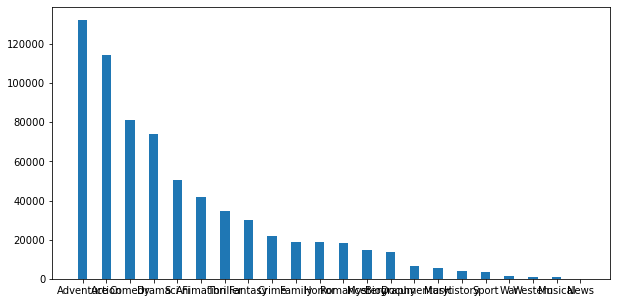

In [57]:
fig = plt.figure(figsize = (10, 5))

plt.bar(new_gf2['genres'], new_gf2['profit_million'], width = 0.4)